In [34]:
import yfinance
import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [35]:
BTC   = yfinance.download('BTC-USD', period='5y', interval='1d', auto_adjust=True)
SP500 = yfinance.download('^GSPC', period='5y', interval='1d'  , auto_adjust=True)
DXY   = yfinance.download('DX-Y.NYB', period='5y', interval='1d', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


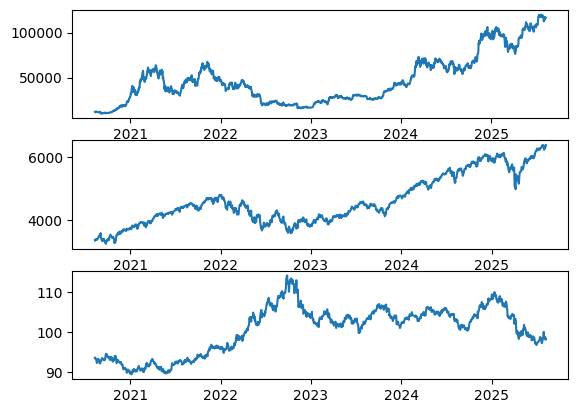

In [36]:
fig, ax = plt.subplots(3,1)

ax[0].plot(BTC['Close'])
ax[1].plot(SP500['Close'])
ax[2].plot(DXY['Close'])
plt.show()

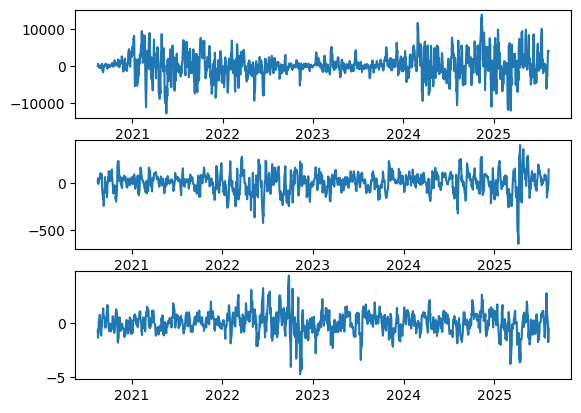

In [37]:
fig, ax = plt.subplots(3,1)
ax[0].plot(BTC['Close'].diff(5))
ax[1].plot(SP500['Close'].diff(5))
ax[2].plot(DXY['Close'].diff(5))
plt.show()

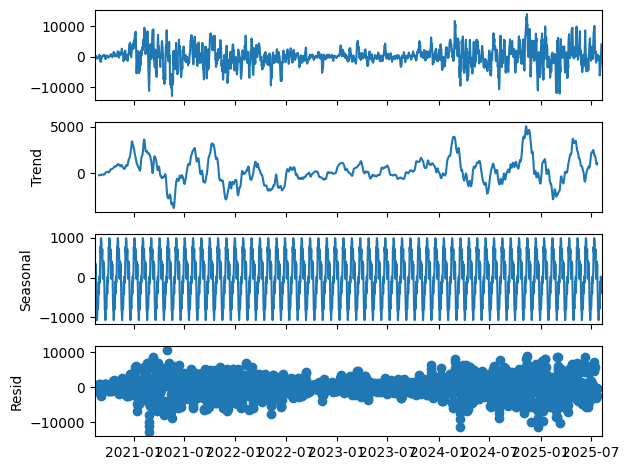

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig = seasonal_decompose(BTC['Close'].diff(5).dropna(), model='additive', period=30)
fig.plot()
plt.show()

In [121]:
data = pd.concat([
    BTC['Close'].apply(lambda x: np.log(x)).diff(5), 
    SP500['Close'].apply(lambda x: np.log(x)).diff(5), 
    DXY['Close'].apply(lambda x: np.log(x)).diff(5)
], axis=1)

In [122]:
data = data.dropna()

In [145]:
def gerador_dados(series, janela_tempo=50):
    X = []
    y = []
    for i in range(len(series) - janela_tempo):
        Xi = series[i:i + janela_tempo].values
        yi =series[i + janela_tempo:i + janela_tempo + 1].values[0][0].reshape(-1, 1)
        X.append(Xi)
        y.append(yi)
    return np.array(X), np.array(y)

In [146]:
X, y = gerador_dados(data)

In [147]:
xtrain, ytrain = X[:int(len(X) * 0.8)], y[:int(len(X) * 0.8)]
xtest, ytest = X[int(len(X) * 0.8)-50:], y[int(len(X) * 0.8)-50:]

In [148]:
xtrain.shape, ytest.shape

((959, 50, 3), (290, 1, 1))

In [149]:
model = keras.models.Sequential([
    keras.layers.GRU(32, return_sequences=True),
    keras.layers.GRU(32, return_sequences=True, recurrent_dropout=0.1),
    keras.layers.GRU(32, recurrent_dropout=0.1),
    keras.layers.Dense(1)
])
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss=keras.losses.mean_squared_error,
    metrics=[keras.metrics.mean_squared_error]
)

model.fit(
    xtrain,
    ytrain,
    validation_data=(xtest, ytest),
    epochs=10,
    shuffle=False
)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0

In [150]:
ytrain.shape

(959, 1, 1)

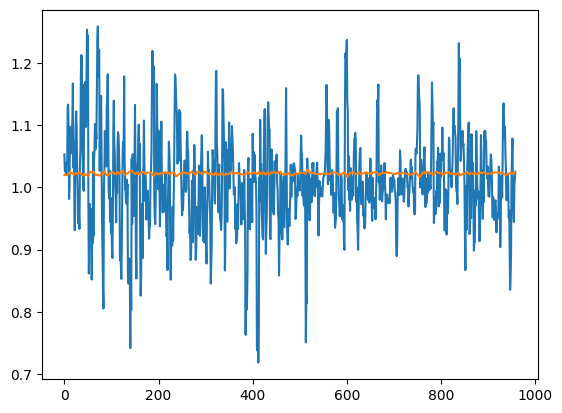

In [ ]:
plt.plot(
    range(len(xtrain)), np.exp(ytrain).ravel()
)
plt.plot(
    range(len(xtrain)), np.exp(model.predict(xtrain, verbose=0))
)